# compare_metrics(model_outputs, metric=None, filter_conditions=None, median=False, show_values=True)


*   **model_outputs (mandatory):**
A list of paths to JSON benchmark files to compare.
*   **metric (optional):**
A single metric name (e.g., "Noise_Floor"), a list of metric names (e.g., ["Noise_Floor", "Dynamic_Range"]), or None to compare all metrics.
*   **filter_conditions (optional):**
A dictionary of filter conditions to apply to the JSON file entries (e.g., {"Indoors": "Yes"}).
*   **median (optional):**
If True, uses the median for comparison instead of the mean. Defaults to False.
*   **show_values (optional):**
If True, displays numeric value labels on top of each bar. Defaults to True.



TO EDIT METRICS, CHANGE **all_metrics** and **units_map** in **plot_metrics_comparison()**












In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)
# compare all metrics
def compute_metrics(data, median):
    metrics = ['Total_Harmonic_Distortion', 'Noise_Floor', 'Dynamic_Range', 'Crest_Factor', 'Signal_Noise_Ratio', 'Waveform_Complexity_Index']
    values = [[entry[m] for m in metrics] for entry in data['files']]
    if median:
        return np.median(values, axis=0)
    else:
        return np.mean(values, axis=0)

# compare singular metric
def compute_metric(data, metric, median):
    values = [entry[metric] for entry in data['files']]
    if median:
        return np.median(values, axis=0)
    else:
        return np.mean(values, axis=0)

def plot_metrics_comparison(values, labels, metrics, median, filter_conditions=None, show_values=True):
    all_metrics = [
        'Total_Harmonic_Distortion',
        'Noise_Floor',
        'Dynamic_Range',
        'Crest_Factor',
        'Signal_Noise_Ratio',
        'Waveform_Complexity_index'
    ]

    units_map = {
        "Total_Harmonic_Distortion": "Ratio",
        "Noise_Floor": "Decibels",
        "Dynamic_Range": "Decibels",
        "Crest_Factor": "Ratio",
        "Signal_Noise_Ratio": "Ratio",
        "Waveform_Complexity_index": "Relative Value"
    }

    # Normalize input to list of metrics
    if metrics is None:
        selected_metrics = all_metrics
    elif isinstance(metrics, str):
        selected_metrics = [metrics]
    else:
        selected_metrics = metrics

    # filter conditions added to title
    filter_str = ''
    if filter_conditions:
        filter_str = f"Filtered by: {', '.join([f'{key}={value}' for key, value in filter_conditions.items()])}"

    # Set up color map for models
    cmap = cm.get_cmap('tab20', len(labels))
    colors = [cmap(i) for i in range(len(labels))]

    # Handle single and multiple metrics correctly
    n = len(selected_metrics)
    rows = (n + 1) // 2 if n > 1 else 1  # Arrange in a grid for multiple metrics
    fig, axs = plt.subplots(rows, 2 if n > 1 else 1, figsize=(14, 5 * rows))

    # Ensure axs is always a list (handles single metric case)
    if n == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, metric in enumerate(selected_metrics):
        ax = axs[i]

        # Extract the correct value for each model
        metric_index = all_metrics.index(metric)
        metric_values = [val[metric_index] if isinstance(val, (list, np.ndarray)) else val for val in values]

        unit = units_map.get(metric, '')

        bars = ax.bar(np.arange(len(labels)), metric_values, color=colors, alpha=0.8)
        ax.set_title(f"{metric} ({'Median' if median else 'Average'})")
        ax.set_ylabel(f"Value ({unit})")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # Show values on bars
        if show_values:
            for bar, value in zip(bars, metric_values):
                ax.annotate(f'{value:.2f} {unit}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

    #  ßRemove extra empty subplots in case of odd number of metrics
    if n > 1 and len(axs) > n:
        for j in range(n, len(axs)):
            fig.delaxes(axs[j])

    fig.suptitle(f"Comparison of {'Median' if median else 'Average'} Metrics\n{filter_str}", fontsize=16)
    fig.legend(bars, labels, loc='lower center', ncol=min(len(labels), 5), bbox_to_anchor=(0.5, -0.01))
    fig.tight_layout(rect=[0, 0.03, 1, .95])
    plt.show()

    def compare_metrics(model_outputs, metric=None, filter_conditions=None, median=False, show_values=True):
    # Load all JSON data
    data_list = [load_json(file) for file in model_outputs]
    labels = [data['top_level_metrics']['audio_model'] for data in data_list]

    # Filter function based on the provided conditions
    def filter_files(data, conditions):
        filtered_files = data['files']
        for key, value in conditions.items():
            filtered_files = [file for file in filtered_files if file.get(key) == value]
        return filtered_files

    # Apply filter if conditions are provided
    if filter_conditions:
        data_list = [
            {**data, 'files': filter_files(data, filter_conditions)}
            for data in data_list
        ]

    if metric is None:
        selected_metrics = None  # means plot all
        averages = [compute_metrics(data, median) for data in data_list]
    elif isinstance(metric, str):
        selected_metrics = [metric]
        averages = [compute_metric(data, metric, median) for data in data_list]
    else:
        selected_metrics = metric
        averages = [compute_metrics(data, median) for data in data_list]

    # Plot
    plot_metrics_comparison(averages, labels, selected_metrics, median, filter_conditions)



Example Usage of Comapre_Metrics


<ipython-input-3-a76bf3650e63>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(labels))


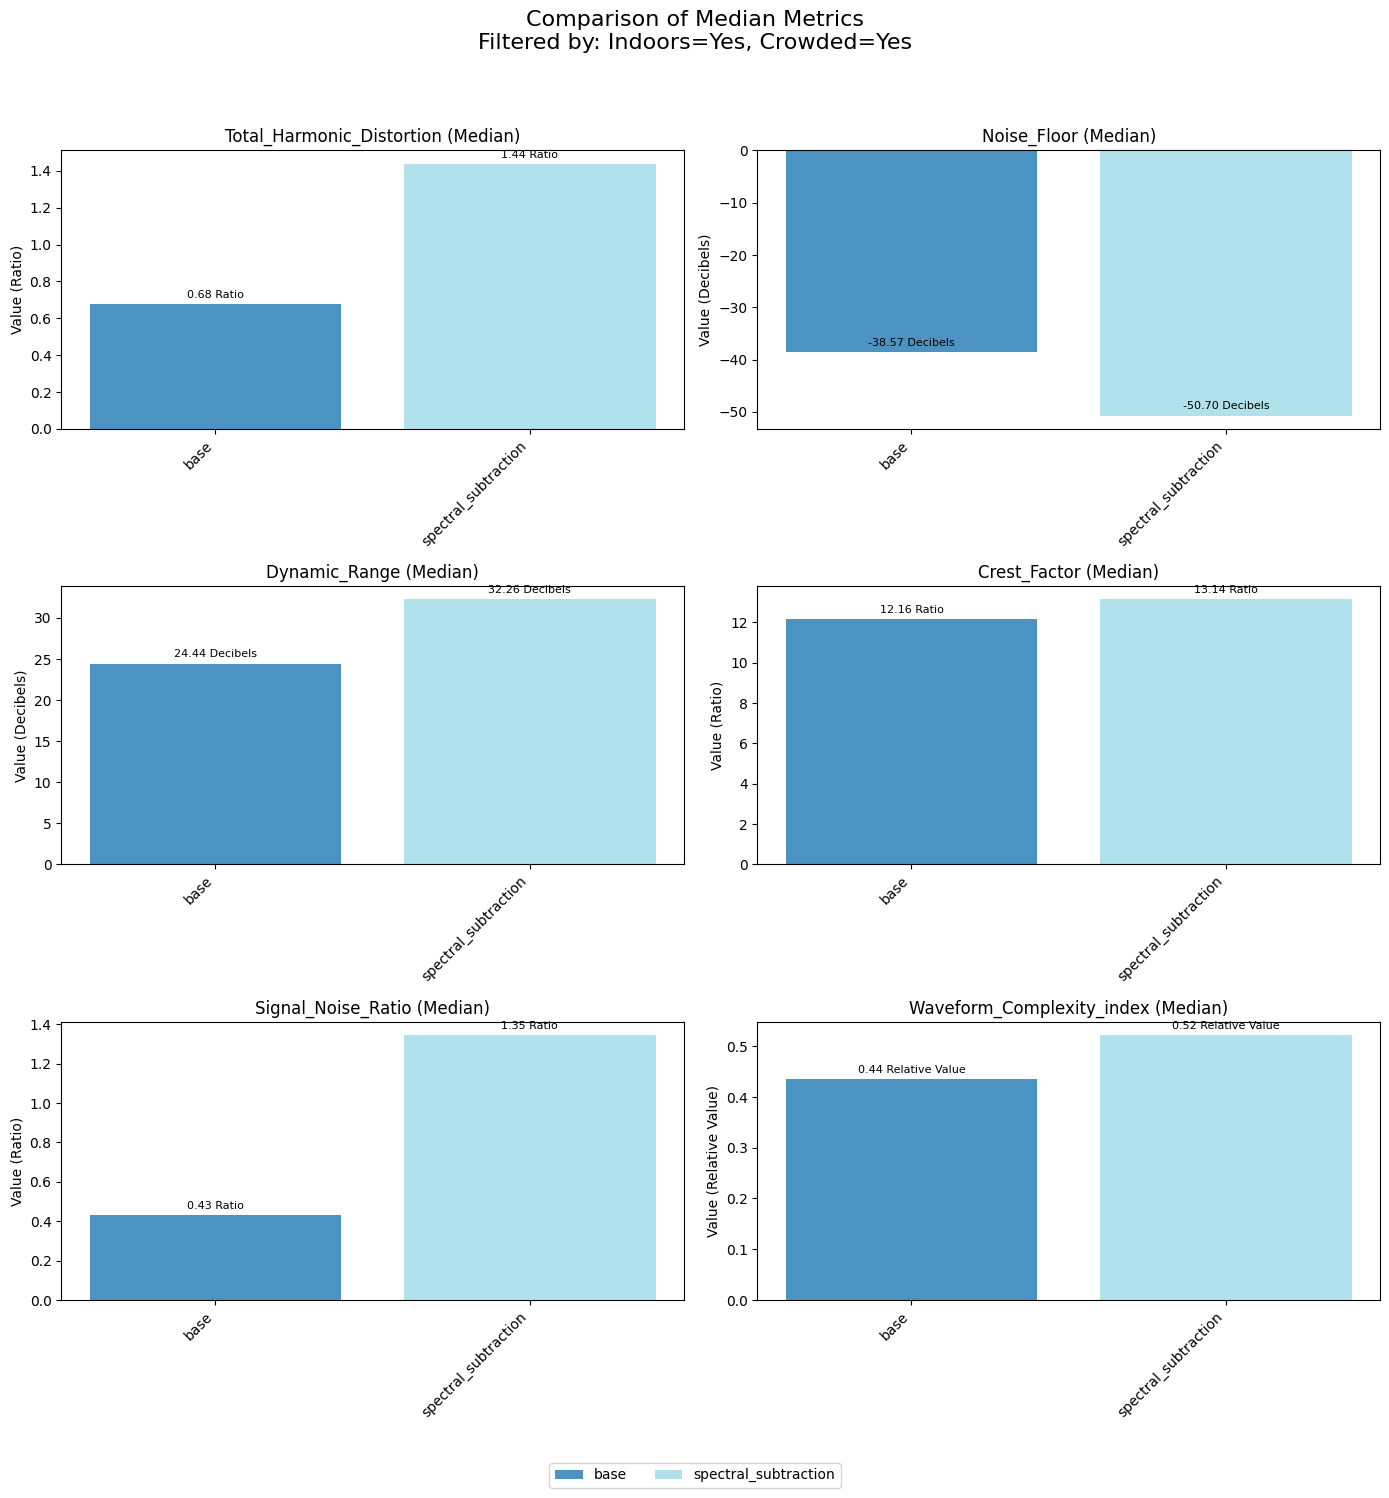

In [ ]:
files = ["base_benchmark_data.json",
         "spectral_subtraction_benchmark_data.json",
         #"dynamic_range_compression_benchmark_data.json",
         #"speechbrain_metricgan-plus-voicebank_benchmark_data.json",
         ]
filter_conditions = {
    "Indoors": "Yes",
    "Crowded": "Yes",
}
metric=["Noise_Floor"]
compare_metrics(files,metric=None, filter_conditions=filter_conditions, median=True)

# compare_metrics(model_outputs, metric=None, filter_conditions=None, median=False, show_values=True)


*   **model_outputs (mandatory):**
A list of paths to JSON benchmark files to compare.
*   **metric (optional):**
A single metric name (e.g., "Noise_Floor"), a list of metric names (e.g., ["Noise_Floor", "Dynamic_Range"]), or None to compare all metrics.
*   **environments (optional):**
A dictionary of filter conditions to apply to the JSON file entries (functionally the same as filter_conditions) (e.g., {"Environment": "A"}).
*   **median (optional):**
If True, uses the median for comparison instead of the mean. Defaults to False.
*   **show_values (optional):**
If True, displays numeric value labels on top of each bar. Defaults to True.



TO EDIT METRICS, CHANGE and **units_map** in **plot_metric_across_environments()**












In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
def compare_environments(model_outputs, environments, metric=None, median=False, show_values=True):
# Load all benchmark files
    def filter_files(data, conditions):
        filtered = data['files']
        for key, value in conditions.items():
            filtered = [file for file in filtered if file.get(key) == value]
        return filtered

    data_list = [load_json(file) for file in model_outputs]
    model_labels = [data['top_level_metrics'].get('audio_model', f'Model {i}') for i, data in enumerate(data_list)]

    # Define metrics to use
    all_metrics = ['Total_Harmonic_Distortion', 'Noise_Floor', 'Dynamic_Range', 'Crest_Factor', 'Signal_Noise_Ratio', 'Waveform_Complexity_Index']
    selected_metrics = all_metrics if metric is None else ([metric] if isinstance(metric, str) else metric)

    for metric_name in selected_metrics:
        # For this metric, get value for each model in each environment
        values = []  # shape: envs × models
        for env in environments:
            env_values = []
            for data in data_list:
                filtered = filter_files(data, env)
                filtered_data = {**data, 'files': filtered}
                value = compute_metric(filtered_data, metric_name, median)
                env_values.append(value)
            values.append(env_values)

        # Plot: x-axis = environments, bars = models
        plot_metric_across_environments(
            metric_name,
            environments,
            values,  # shape: envs × models
            model_labels,
            median,
            show_values
        )
def plot_metric_across_environments(metric, environments, values_matrix, model_labels, median, show_values):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm

    # Define metric units
    units_map = {
        "Total_Harmonic_Distortion": "Ratio",
        "Noise_Floor": "dB",
        "Dynamic_Range": "dB",
        "Crest_Factor": "dB",
        "Signal_Noise_Ratio": "dB",
        "Waveform_Complexity_index": "Relative Value"
    }
    unit = units_map.get(metric, "")

    n_envs = len(environments)
    n_models = len(model_labels)
    x = np.arange(n_envs)
    bar_width = 0.8 / n_models

    cmap = cm.get_cmap('tab20', n_models)
    colors = [cmap(i) for i in range(n_models)]

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model_name in enumerate(model_labels):
        model_values = [env[i] for env in values_matrix]
        ax.bar(x + i * bar_width, model_values, bar_width, label=model_name, color=colors[i])

        if show_values:
            for j, val in enumerate(model_values):
                ax.annotate(f'{val:.2f} {unit}', xy=(x[j] + i * bar_width, val),
                            xytext=(0, 3), textcoords='offset points',
                            ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x + (bar_width * (n_models - 1)) / 2)
    ax.set_xticklabels([str(env) for env in environments], rotation=45, ha='right')
    ax.set_ylabel(f"Value ({unit})")  # ✅ Ensures correct Y-axis units
    ax.set_title(f"{metric} ({'Median' if median else 'Average'}) by Environment")
    ax.legend()
    fig.tight_layout()
    plt.show()



Example Usage of Comapre_Environments


<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


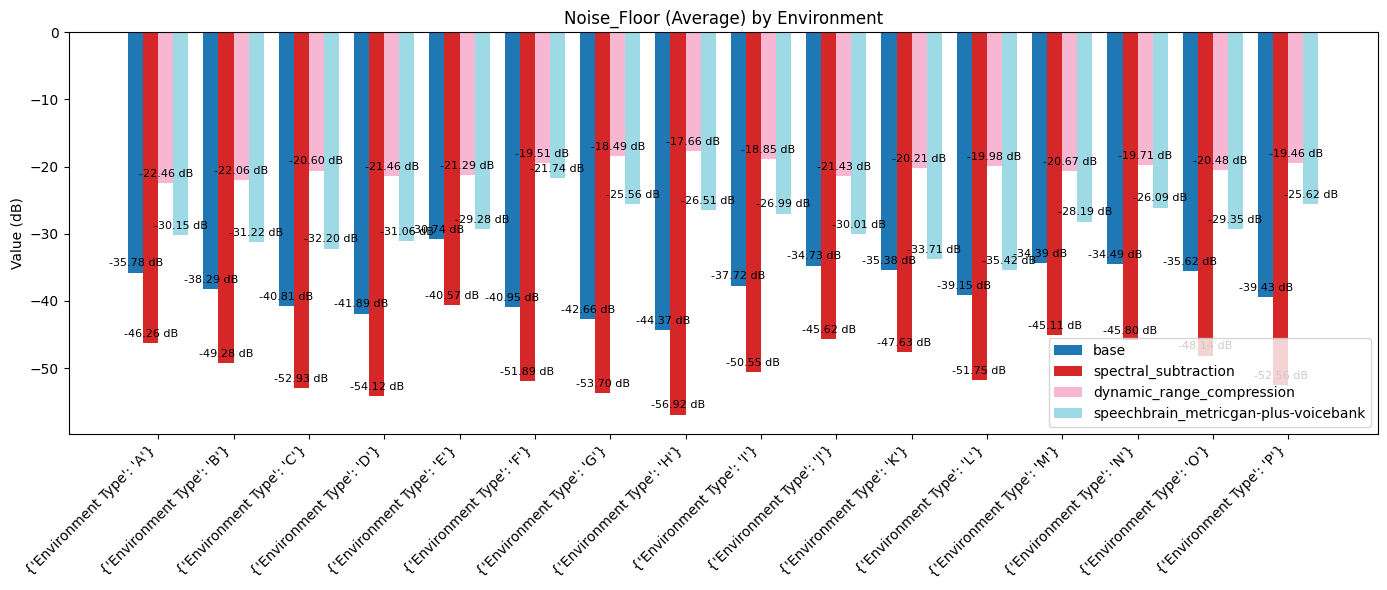

<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


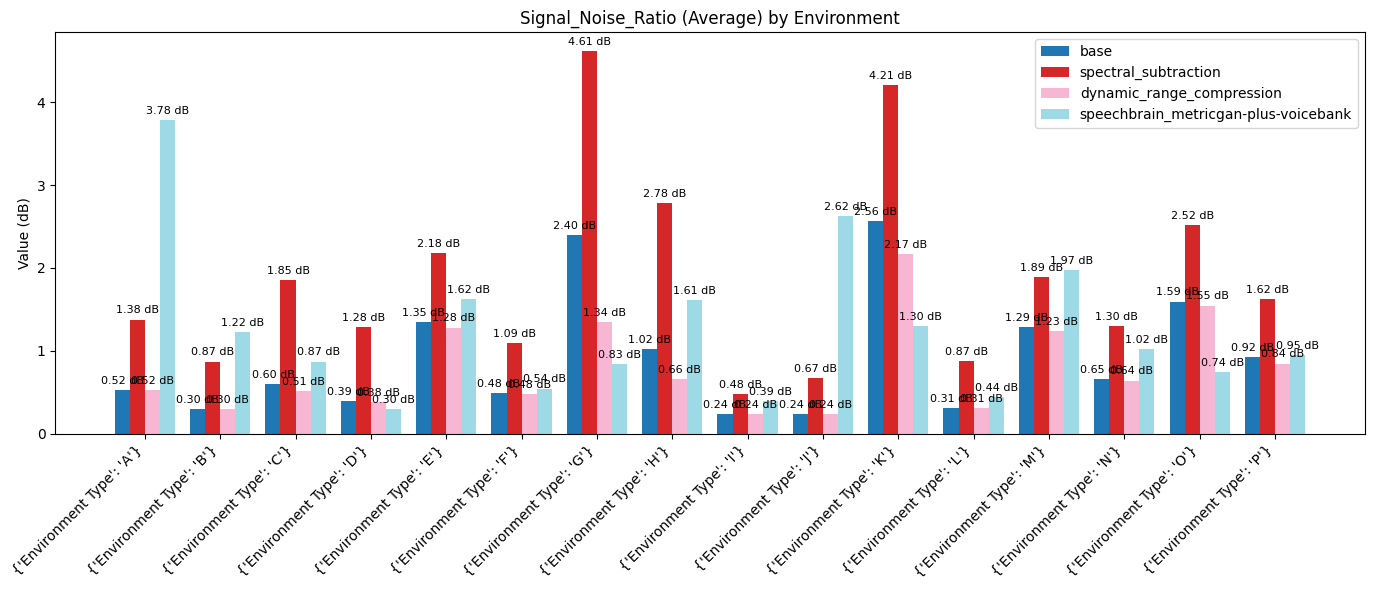

<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


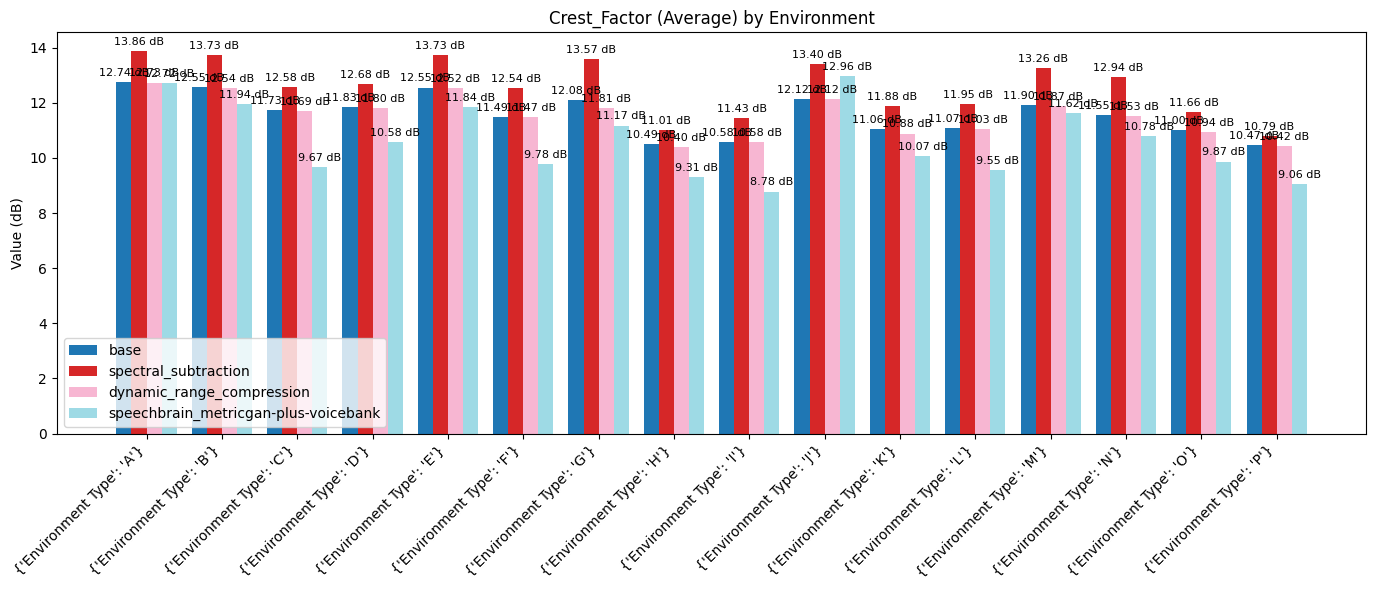

<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


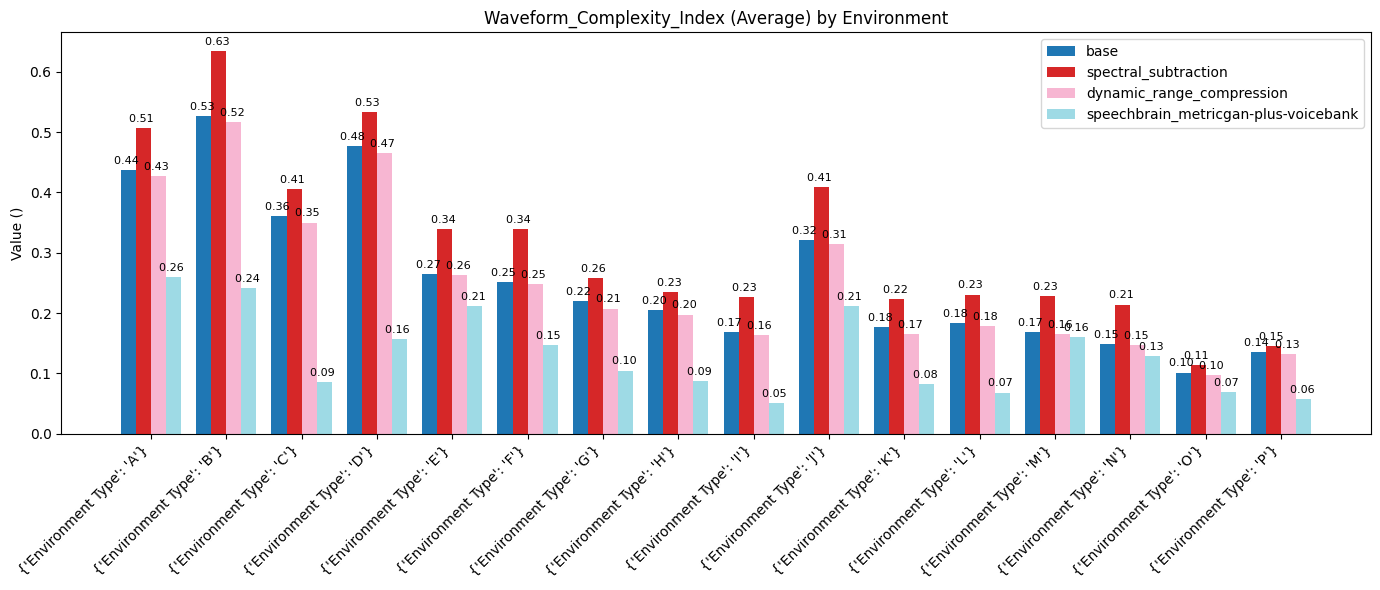

<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


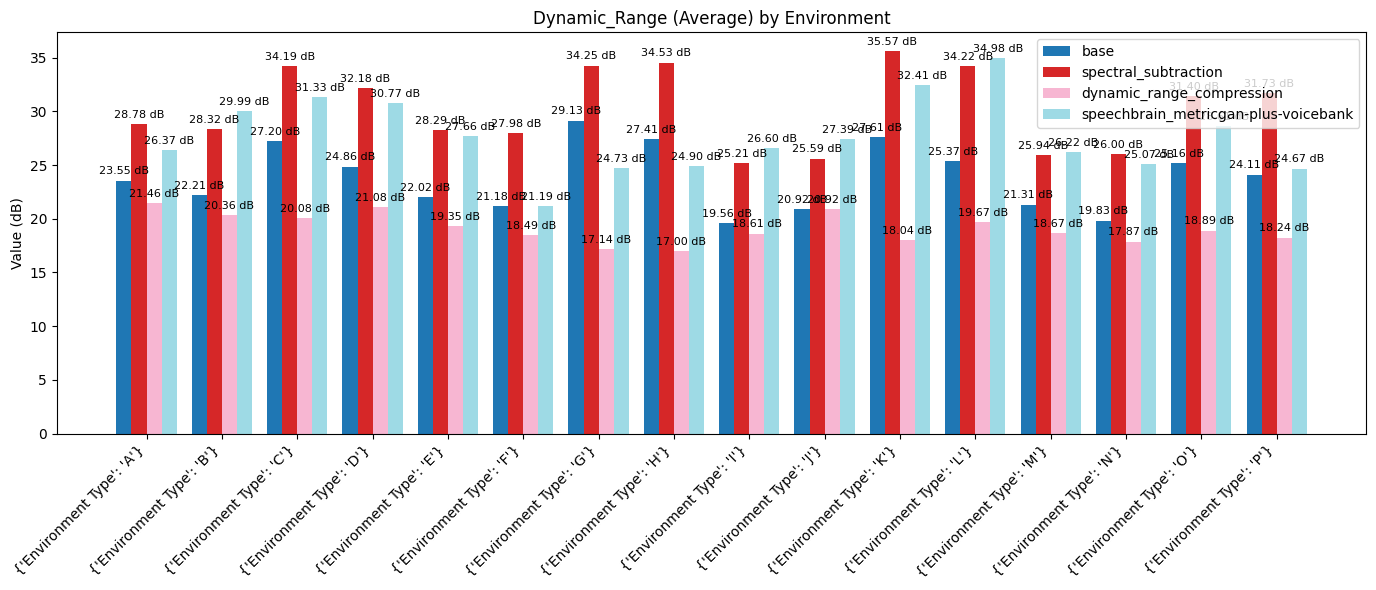

<ipython-input-6-5f3353347d55>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_models)


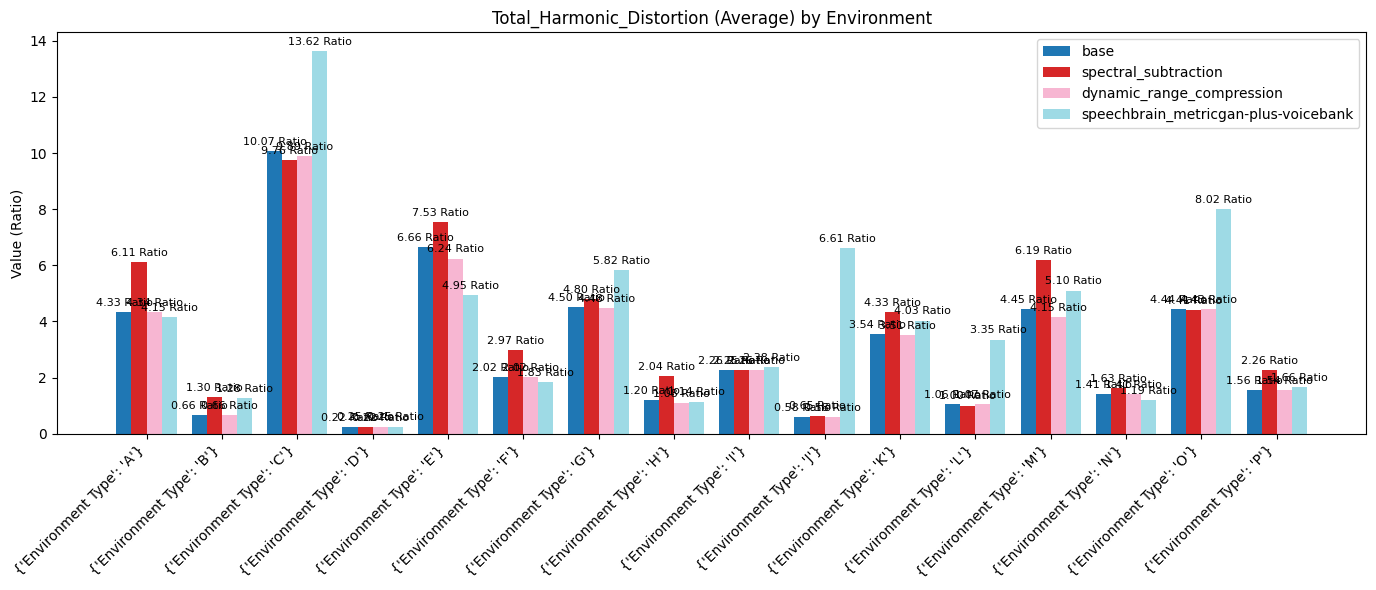

In [ ]:
compare_environments(
    model_outputs=[
        "base_benchmark_data.json",
        "spectral_subtraction_benchmark_data.json",
        "dynamic_range_compression_benchmark_data.json",
        "speechbrain_metricgan-plus-voicebank_benchmark_data.json",
    ],
    environments=[
        {"Environment Type": "A"},
        {"Environment Type": "B"},
        {"Environment Type": "C"},
        {"Environment Type": "D"},
        {"Environment Type": "E"},
        {"Environment Type": "F"},
        {"Environment Type": "G"},
        {"Environment Type": "H"},
        {"Environment Type": "I"},
        {"Environment Type": "J"},
        {"Environment Type": "K"},
        {"Environment Type": "L"},
        {"Environment Type": "M"},
        {"Environment Type": "N"},
        {"Environment Type": "O"},
        {"Environment Type": "P"},
    ],
    metric=["Noise_Floor",
            "Signal_Noise_Ratio",
            "Crest_Factor",
            "Waveform_Complexity_Index",
            "Dynamic_Range",
            "Total_Harmonic_Distortion"
            ],
    median=False,
    show_values=True
)
